<a href="https://colab.research.google.com/github/EduMoura321/Non-linear-systems/blob/main/flutter_nao_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autovalores: [-0.05417263+14.11982488j -0.05417263-14.11982488j
 -0.86355364 +7.52142167j -0.86355364 -7.52142167j
 -1.84832458 +0.j         -4.99999999 +0.j
 -5.         +0.j         -1.         +0.j
 -2.         +0.j         -2.         +0.j        ]
Parte real: [-0.05417263 -0.05417263 -0.86355364 -0.86355364 -1.84832458 -4.99999999
 -5.         -1.         -2.         -2.        ]
The solver successfully reached the end of the integration interval.


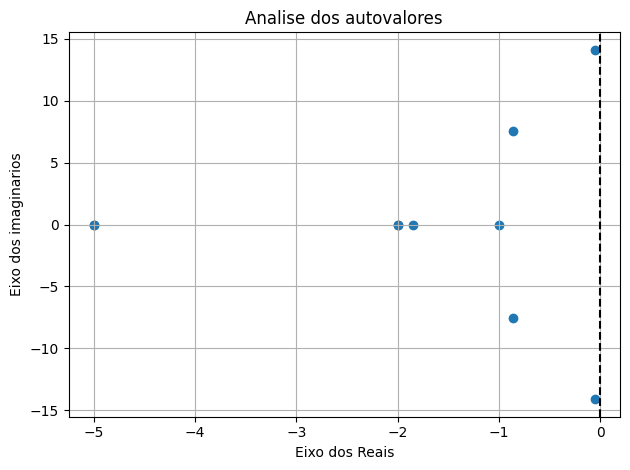

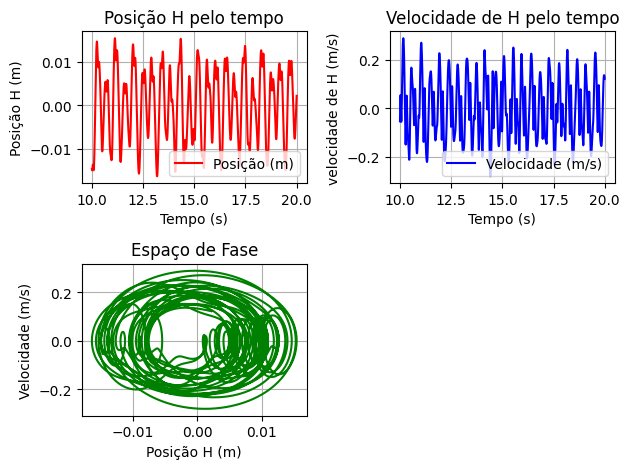

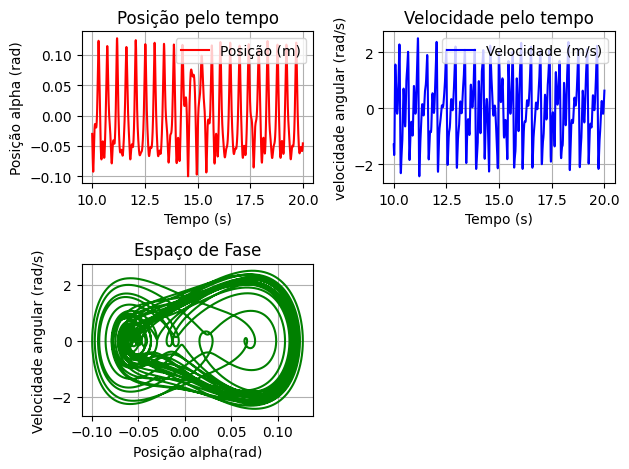

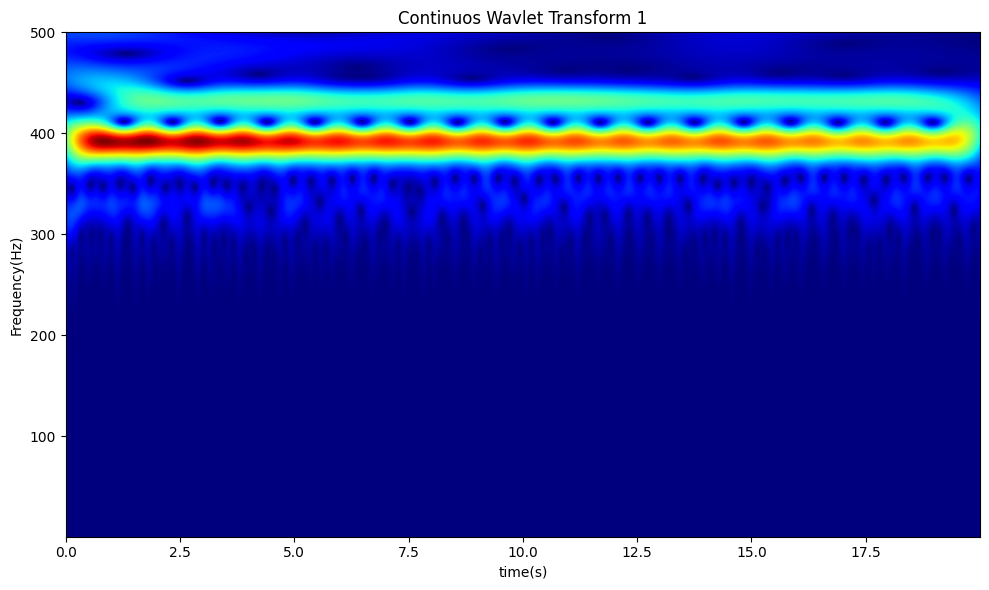

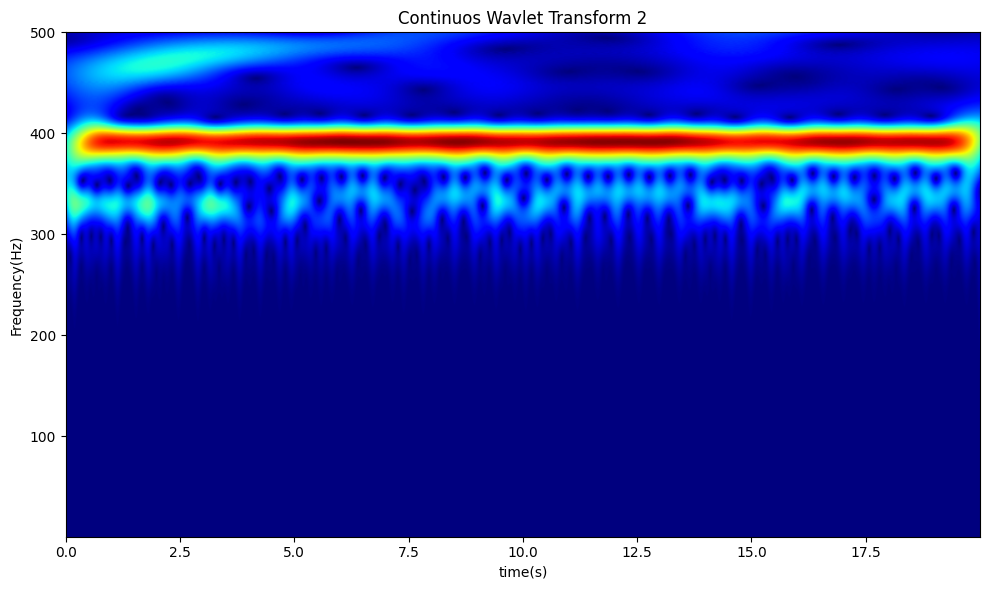

In [1]:
'''
=====================================================================
Nome do programa: Simulação de aerofolio sob força de Padé
Data: 19/09/2025
Linguagem: Phyton
Depêndencias: Mathplotlib, Numpy e scipy
--------------------------------------------------------------------
Nome: Eduardo Moura Ventorim
Instituto de Física
UFMS - Campo Grande
Descrição: Programa que realiza a partir de metódos númericos a
solução do dominio temporal da EDO que descreve um aerofolio em regime
aerodinamico simples, e analisa seu comportamente passivo de efeito flutter
===================================================================
'''
#====================================================================
#Bibliotecas utilizadas:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
from scipy import signal
from scipy.special import hankel2
import pywt
#=====================================================================
#parametros físicos do sistema
C_aero = 0.1 #amortecimento aerodinamico[M/s]
L = 0.28 #envergadura do aviao [M]
b = 0.104 #metade da corda [M]
c = 0.1 #tamanho total da corda[M]
xab = 0.084 #distancia do C.g e meio da corda [M]
m = 8.00 #massa de mergulho [Kg] d
Ig = 0.0505 #momento de inercia do mergulho [Kg * m^2]
kh = 2844.4 #rigidez mola transversal [N/M]
ka = 3.0 #rigidez mola torcional [N/rad] d
U = 35 #velocidade do escoamento[M/s]
p = 1.225 #densidade do ar [Kg/m^3]
e = 0.00
ch = 6.6373
ca = 0.0468 # valores retirados do artigo do ITA
Fc = 0.08
wf = 8.0 #freq forc extern
A = 5.0 #amp forc extern
#======================================================================
#matriz de força dinamica do modelo
def theodorsen(k_in):
    k = np.asarray(k_in, dtype=float)
    C = np.empty_like(k, dtype=complex)
    small = np.isclose(k, 0.0, atol=1e-12)
    nonzero = ~small
    if np.any(nonzero):
        H0 = hankel2(0, k[nonzero])
        H1 = hankel2(1, k[nonzero])
        C[nonzero] = H1/ (H1 + 1j * H0)
    if np.any(small):
        C[small] = 1.0 + 0j
    return C.item() if np.isscalar(k_in) else C
def Mat_theordsem(k):
    k = np.asarray(k, dtype=complex)
    #func theor
    k_for_c = np.abs(k.real) if np.iscomplexobj(k) else np.abs(k)
    Ck = theodorsen(k_for_c)
    Mat_transf1 = np.array([
    [0,      -2*np.pi       ],
    [0,       4*np.pi*b*e  ]
    ], dtype=complex)

    Mat_transf2 = np.array([
    [-2*np.pi*(k/b), 0       ],
    [ 4*np.pi*k*e  ,       0 ]], dtype=complex)

    q = 0.5 * p *C_aero*L*U**2
    Mtt =  q*(Ck* Mat_transf1 + (Ck* Mat_transf2))
    return Mtt
#=====================================================================
#aproximação racional de roger ajustada com tikhonov
def roger_fit(Mats,S_usd, gammas, ridge=1e-6):
    s_arr = np.array(S_usd, dtype=complex)
    m = len(s_arr)
    n = Mats.shape[1]
    r = len(gammas)
    nterms = 3 + r  # A0, A1, r*A_i

    Phi = np.zeros((m, nterms), dtype=complex)
    for idx, s in enumerate(s_arr):
       Phi[idx, :] = [1,0, s] + [1.0/ (s+g) for g in gammas]
    A0 = np.zeros((n, n), dtype=float)
    A1 = np.zeros((n, n), dtype=float)
    Ais = [np.zeros((n, n), dtype=float) for _ in range(r)]
    A_real = np.vstack([Phi.real, Phi.imag])
    for i in range(n):
        for j in range(n):
            y_complex = Mats[:,i,j]
            b_real = np.hstack([y_complex.real, y_complex.imag])  # (2m,)
            theta, *_ = np.linalg.lstsq(A_real, b_real, rcond=None)  # theta shape (nterms,)
            A0[i, j] = theta[0]
            A1[i, j] = theta[1]
            for k_g in range(r):
                Ais[k_g][i, j] = theta[2 + k_g]

    return A0, A1, Ais
#=====================================================================
#espaço de estado novo:
def buildar_novo_esp(M,C_estru,K,A0,A1,Ais, Gammas):
    n = M.shape[0]
    r = len(Ais)
    Ntotal = 2*n + r*n
    A = np.zeros((Ntotal, Ntotal))
    Minv = np.linalg.inv(M)
    A[0:n, n:2 * n] = np.eye(n)

    #dinamica estrutrual
    A[n:2 * n, 0:n] = -Minv @ (K - A0)
    A[n:2 * n, n:2 * n] = -Minv @ (C_estru - A1)

    #dinamica dos lags
    for i, (Ai,gamma) in enumerate(zip(Ais, Gammas)):
        row =  2*n + i*n
        A[row:row + n, n:2 * n] = np.eye(n)
        A[row:row + n, row:row + n] = -gamma * np.eye(n)
        # Acoplamento do lag na equação estrutural
        A[n:2 * n, row:row + n] += -Minv @ Ai
    return A
#=====================================================================
if __name__ == "__main__":
    M = np.array([[m ,xab*m],
                  [xab*m , Ig+m*(xab)**2]], dtype=float) #matriz de massa
    K = np.array([[kh, 0],[0,ka]],  dtype=float) #matriz de rigidez
    C_estru = np.array([[ch,0],[0,ca]], dtype=float)#Matriz de amortecimento
    #pontos de amostragem de frequência
    omegas = np.linspace(0.5,8, 12)
    S_usd = 1j*(omegas*b/U)
    #constantes de decaimento dos lags
    gammas = [1.0,2.0,5.0]
    #ja deixa calculado mat theordsem para optimizar cod
    Mats = np.zeros((len(S_usd), 2, 2),dtype=complex)
    for i, s in enumerate(S_usd):
        Mats[i, :, :] = Mat_theordsem(s)
    #ajuste de roger
    A0,A1,Ais = roger_fit(Mats, S_usd, gammas)
    #monta espaço de estado
    A_aum = buildar_novo_esp(M,C_estru,K, A0,A1,Ais, gammas)
#=====================================================================
#achar autovalores
eigval = np.linalg.eigvals(A_aum)
print('Autovalores:', eigval)
print('Parte real:', eigval.real)

#simular no tempo
# condições iniciais
n = M.shape[0]  # número de GDLs
r = len(Ais)  # número de lags
Ntotal = 2 * n + r * n  # tamanho total do sistema aumentado

X0 = np.zeros(Ntotal)  # todos estados inicialmente zero
X0[0] = 0.01    # pequeno deslocamento inicial no q1
X0[1] = 0.01 + 0.001 # pequeno deslocamento inicial no q2

# não-linearização
Minv = np.linalg.inv(M)
alpha2 = np.array([0,-30])
alpha3 = np.array([0,6600.0])
alpha4 = np.array([0,-22000])
alpha5 = np.array([0, 48000 ])
def f_nl(q):
  return  alpha2*(q ** 2) + alpha3 * (q ** 3) + alpha4 * (q ** 4) + alpha5 * (q**5)
def f_ext(t, q):
  F = np.zeros(n)
  F[0] = A * np.sin(wf*t) #forca em H
  F[1] = 0 # momento torcional em alpha (sem)
  return F
def sys_aug(t, X):
  dX = A_aum @ X
  q = X[0:n]

  fnl = f_nl(q)
  fext = f_ext(t, q)

  dX[n:2 * n] += -Minv @ fnl + Minv @ fext

  return dX
#-----------------------------------------------------
# simulação temporal
t_span = (0, 20)
dt = 0.0001
t_eval = np.arange(t_span[0], t_span[1], dt)

sol = solve_ivp(sys_aug, t_span, X0,method='Radau',t_eval=t_eval, atol=1e-6, rtol=1e-4, max_step=0.05)
print(sol.message)
#=====================================================================
# Pega os estados

q1 = sol.y[0, :] #Altura
q2 = sol.y[1, :] #Angulo de ataque
dq1 = sol.y[n, :] #velocidade altura
dq2 = sol.y[n + 1, :] #velocidade angular
t_transiente1 = 10.0
t1 = sol.t
ind = np.where( sol.t > t_transiente1)[0]
q1t = q1[ind]
q2t = q2[ind]
dq1t = dq1[ind]
dq2t = dq2[ind]
ttransient = t1[ind]
#=====================================================================
#plot dos grafícos
plt.figure()
plt.scatter(eigval.real, eigval.imag,)
plt.axvline(0, color='k',linestyle='--')
plt.title('Analise dos autovalores')
plt.grid(True)
plt.xlabel('Eixo dos Reais')
plt.ylabel('Eixo dos imaginarios')
plt.tight_layout()
plt.show()
#---------------------------------------------------------------------------
#gráficos de altura

#Gráfico de posíção
plt.figure()
plt.subplot(2,2,1)
plt.plot(ttransient, q1t, label='Posição (m)', color='red')
plt.legend()
plt.title('Posição H pelo tempo')
plt.grid(True)
plt.xlabel('Tempo (s)')
plt.ylabel('Posição H (m)')

#gráfico de velocidade
plt.subplot(2,2,2)
plt.plot(ttransient, dq1t, label='Velocidade (m/s)', color='blue')
plt.title('Velocidade de H pelo tempo')
plt.legend()
plt.grid(True)
plt.xlabel('Tempo (s)')
plt.ylabel('velocidade de H (m/s)')

#gráfico de espaço de fase
plt.subplot(2,2,3)
plt.plot(q1t, dq1t, color='green')
plt.title('Espaço de Fase')
plt.grid(True)
plt.ylabel('Velocidade (m/s)')
plt.xlabel('Posição H (m)')

plt.tight_layout()
plt.show()
#------------------------------------------------------------------
#gráficos rotacionais
# Gráfico de posíção
plt.figure()
plt.subplot(2, 2, 1)
plt.plot(ttransient, q2t, label='Posição (m)', color='red')
plt.legend()
plt.title('Posição pelo tempo')
plt.grid(True)
plt.xlabel('Tempo (s)')
plt.ylabel('Posição alpha (rad)')

# gráfico de velocidade
plt.subplot(2, 2, 2)
plt.plot(ttransient, dq2t, label='Velocidade (m/s)', color='blue')
plt.title('Velocidade pelo tempo')
plt.legend()
plt.grid(True)
plt.xlabel('Tempo (s)')
plt.ylabel('velocidade angular (rad/s)')

# gráfico de espaço de fase
plt.subplot(2, 2, 3)
plt.plot(q2t, dq2t, color='green')
plt.title('Espaço de Fase')
plt.grid(True)
plt.ylabel('Velocidade angular (rad/s)')
plt.xlabel('Posição alpha(rad)')

plt.tight_layout()
plt.show()
#======================================================================
#Aplicacao da wavelet gdl1
time = t_eval
wavelet = "cmor1.5-1.0"
widths = np.geomspace(1, 1024, num=500)
sampling_period = np.diff(time).mean()
step = 20 # pega 1 ponto a cada 1000
q1_cwt = q1[::step]
time_cwt = t_eval[::step]
cwtmat, freqs = pywt.cwt(q1_cwt, widths, wavelet, sampling_period=np.diff(time_cwt).mean())
cwtmat = np.abs(cwtmat)
#plot da wavelet
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(np.abs(cwtmat), extent=[time_cwt[0], time_cwt[-1], freqs[-1], freqs[0]], aspect='auto', cmap='jet', origin='lower')
ax.set_xlabel('time(s)')
ax.set_ylabel("Frequency(Hz)")
ax.set_title('Continuos Wavlet Transform 1')
plt.tight_layout()
plt.show()
#=======================================================================
#Aplicacao da wavelet gld2
time = t_eval
wavelet = "cmor1.5-1.0"
widths = np.geomspace(1, 1024, num=500)
sampling_period = np.diff(time).mean()
q2_cwt = q2[::step]
cwtmat, freqs = pywt.cwt(q2_cwt, widths, wavelet, sampling_period=np.diff(time_cwt).mean())
cwtmat = np.abs(cwtmat)
#plot da wavelet
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(np.abs(cwtmat), extent=[time_cwt[0],time_cwt[-1], freqs[-1], freqs[0]], aspect='auto', cmap='jet', origin='lower')
ax.set_xlabel('time(s)')
ax.set_ylabel("Frequency(Hz)")
ax.set_title('Continuos Wavlet Transform 2')
plt.tight_layout()
plt.show()

In [ ]:
#lyapunov estimations
#verificacao direta de caos no sistema
# 1/12/26
#por Eduardo Moura Ventorim
#=====================================================
#definir jacobiano da funcao sys aug
import jax.numpy as jnp
from jax import jacfwd
def sys_aug_jac(X, t):
  dX = A_aum @ X
  q = X[0:n]

  fnl = f_nl(q)
  fext = f_ext(t, q)

  corr = jnp.zeros_like(X)
  corr = corr.at[n:2*n].set(-Minv @ fnl + Minv @ fext)

  return dX + corr
J = jacfwd(sys_aug_jac)
t0 = 0.0

#=====================================================
#metodo de lyapuno
#codigo do professor varanis
nc = len(X0)
def lyapunov_exponent(sisODE, X0, t_span, dt=0.01):
  def variational_equations(t,X):
    x = X[:nc]
    d = X[nc:].reshape((nc,nc))

    dx = sys_aug(t,x)

    dFdx = J(x,t)
    dDdt = dFdx @ d
    return np.hstack([dx, dDdt.flatten()])

  nc = len(X0)
  M = np.eye(nc)
  X0 = np.hstack([X0, M.flatten()])
  times = np.arange(t_span[0] + dt,t_span[1],dt)
  lyapunov_exp = np.zeros(len(times))

  sol = solve_ivp(variational_equations, t_span, X0, method='RK45', t_eval=times)

  #calcular evolucao destes
  for i, t in enumerate(times):
    M = sol.y[nc:, i].reshape((nc,nc))

    Q, R = np.linalg.qr(M)
    lyapunov_exp[i] = np.log(np.abs(np.diag(R))).sum()/t
  return times, lyapunov_exp

ci = X0
times, lyapunov_exp = lyapunov_exponent(sys_aug, X0, t_span=(0,100))

plt.figure(figsize=(10,0))
plt.plot(times, lyapunov_exp, label='Expoente lyapunov')
plt.xlabel('Tempo(s)')
plt.ylabel('Expoente de Lyapunov')
plt.title('Evolucao do Expoente Lyapunov')
plt.grid(True)
plt.legend()
plt.show()



#----------------------------------------------------


Simulando amplitude = 0.0
Simulando amplitude = 0.020202020202020204
Simulando amplitude = 0.04040404040404041
Simulando amplitude = 0.06060606060606061
Simulando amplitude = 0.08080808080808081
Simulando amplitude = 0.10101010101010102
Simulando amplitude = 0.12121212121212122
Simulando amplitude = 0.14141414141414144
Simulando amplitude = 0.16161616161616163
Simulando amplitude = 0.18181818181818182
Simulando amplitude = 0.20202020202020204
Simulando amplitude = 0.22222222222222224
Simulando amplitude = 0.24242424242424243
Simulando amplitude = 0.26262626262626265
Simulando amplitude = 0.2828282828282829
Simulando amplitude = 0.30303030303030304
Simulando amplitude = 0.32323232323232326
Simulando amplitude = 0.3434343434343435
Simulando amplitude = 0.36363636363636365
Simulando amplitude = 0.38383838383838387
Simulando amplitude = 0.4040404040404041
Simulando amplitude = 0.42424242424242425
Simulando amplitude = 0.4444444444444445
Simulando amplitude = 0.4646464646464647
Simulando am

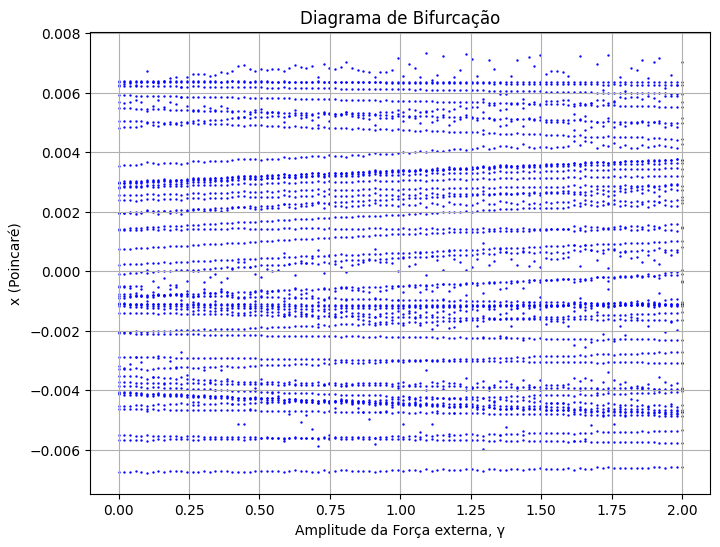

In [22]:
#eduardo Moura Ventorim
#aplicar diagrama de bifurcacao
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d


t_total = 100 # tempo total de simulação
dt = 0.001
t_eval = np.arange(0, t_total, dt)
t_transient = 50 # Tempo de transiente a descartar
T_period = 2 * np.pi / wf # Período da forçante
#  Definir os valores de amplitude da forca para varredura (ex.: de 0.3 a 0.7, com 200 pontos)
Amp_values = np.linspace(0, 2, 100)
#  Listas para armazenar os pontos do diagrama de bifurcação
x_bif = [] #
amp_bif = [] #
def f_ext_db(t, q, Al):
  F = np.zeros(n)
  F[0] = Al * np.sin(wf*t) #forca em H
  F[1] = 0 # momento torcional em alpha (sem)
  return F
def sys_aug_db(t, X, Al):
  dX = A_aum @ X
  q = X[0:n]

  fnl = f_nl(q)
  fext = f_ext_db(t, q, Al)

  dX[n:2 * n] += -Minv @ fnl + Minv @ fext

  return dX

for ampp in Amp_values:
  print("Simulando amplitude =", ampp)
  # --- D. Loop de Simulação Iterativa ---
  sol2 = solve_ivp(lambda t,y: sys_aug_db(t, y, ampp), [0, t_total], X0, method='Radau', rtol=1e-3, atol=1e-3)
  t_val = sol2.t
  x_val = sol2.y[0]
  n_trans = int(t_transient / T_period)
  n_samples = 50

  t_poincare = T_period * np.arange(
    n_trans,
    n_trans + n_samples
    )
  interp_x = interp1d(sol2.t, sol2.y[0], kind='cubic')

  x_pc = interp_x(t_poincare)
  for val in x_pc:
    amp_bif.append(ampp)
    x_bif.append(val)
# Plot do diagrama de bifurcação
plt.figure(figsize=(8,6))
plt.scatter(amp_bif, x_bif, s=0.5, color='blue')
plt.xlabel('Amplitude da Força externa, γ')
plt.ylabel('x (Poincaré)')
plt.title('Diagrama de Bifurcação')
plt.grid(True)
plt.show()

In [ ]:
#diagrama de bifurcacao
#---------------------------------------------------------------------------
#variacao de param
U_var = np.linspace(20.0, 45, 400)
t_transiente1 = 2.0
dt = 1e-4
t_eval = np.arange(0, 100, dt)
amp_marc = []
#---------------------------------------------------------------------------
#chamada theordsem
def Mat_theordsem2(k, U_n):
    k = np.asarray(k, dtype=complex)
    #func theor
    k_for_c = np.abs(k.real) if np.iscomplexobj(k) else np.abs(k)
    Ck = theodorsen(k_for_c)
    Mat_transf1 = np.array([
    [0,      -2*np.pi       ],
    [0,       4*np.pi*b*e  ]
    ], dtype=complex)

    Mat_transf2 = np.array([
    [-2*np.pi*(k/b), 0       ],
    [ 4*np.pi*k*e  ,       0 ]], dtype=complex)

    q = 0.5 * p *C_aero*L*U_n**2
    Mtt =  q*(Ck* Mat_transf1 + (Ck* Mat_transf2))
    return Mtt
#-----------------------------------------------------------------------------
#prepara sistema para dif U
def montar_sistem_p_u(U_n):
  S_usd = 1j*(omegas*b/U_n)
  #ja deixa calculado mat theordsem para optimizar cod
  Mats = np.zeros((len(S_usd), 2, 2),dtype=complex)
  for i, s in enumerate(S_usd):
      Mats[i, :, :] = Mat_theordsem2(s, U_n)
  #ajuste de roger
  A0,A1,Ais = roger_fit(Mats, S_usd, gammas)
  #monta espaço de estado
  A_aum2 = buildar_novo_esp(M,C_estru,K, A0,A1,Ais, gammas)
  return A_aum2, Ais
def sys_aug2(t,X,A_aum2,Ais):
  dX = A_aum2 @ X
  q = X[0:n]
  fnl = f_nl(q)
  dX[n:2*n] += -Minv @ fnl
  return dX
X_atual = np.zeros(len(X0)) # Garante que tem o tamanho certo
X_atual[1] = 0.05 # Perturbação no pitch
t_span = (0, 100)
for U_n in U_var:
  print(U_n)
  A_aum2, Ais = montar_sistem_p_u(U_n)
  solb = solve_ivp(lambda t, X: sys_aug2(t, X,A_aum2, Ais), t_span, X0, t_eval=t_eval)
  t_val = solb.t
  #pego pontos depois transient (dica da Ia)
  n_pontos = len(solb.t)
  pont_t = int(n_pontos *0.7)
  x_vals = solb.y[1, pont_t:]
  amp = (np.max(x_vals) - np.min(x_vals))/2
  amp_marc.append(amp)
  X_atual = solb.y[:, -1]
plt.figure(figsize=(8,6))
plt.plot(U_var, amp_marc, color='blue')
plt.xlabel("U (m/s)")
plt.ylabel("Amplitude de pitch")
plt.title('Digrama de Bifurcacao')
plt.axhline(0, color='black', linewidth=1)
plt.grid(True)
plt.show()



/tmp/ipython-input-4033792253.py:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s = float(C @ X) - Sref   # scalar


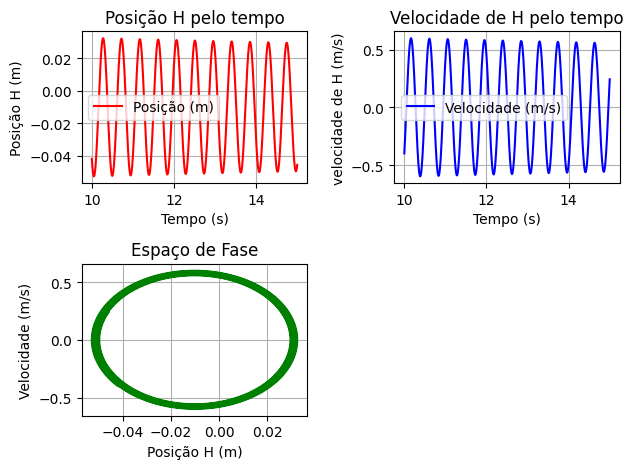

In [3]:
# === parâmetros de atuação (ajusta conforme físico) ===
u_min = -50.0
u_max = 50.0

# arrays para log (opcionais)
log_t = []
log_u = []
log_ueq = []
log_usw = []
log_s = []
#---------------------------------------------------------------
def sat(x):
  return np.where(np.abs(x) <= 1.0, x, np.sign(x))
Bq = np.array([[1], [1]])
Bt = Minv@Bq #termo de entrada de forca de controle
m = 1 #colunas
g = np.zeros((Ntotal, m))
g[n:2 * n,0] = Bt[:,0] #matriz de controle
#----------------------------
alp = np.array([[10, 0]])
bet = np.array([[1.0, 0]])
phi = 0.01
k = 100
#----------------------------
I = np.eye(n)
zer = np.zeros((1, Ntotal - 2*n))
C = np.hstack((alp,bet,zer))
Cg = C @ g
def r(t):
  return np.zeros((n,))
def r_dot(t):
  return np.zeros((n,))  #apenas para estados fisicos do sistem (errei tentando aplicar para rogers states artificiais )
def r_ddot(t):
  return np.zeros((n,))
#--------------------------------------------

def usmc(t, X):
    phi = 0.5
    k = 300
    # estados físicos
    q = X[0:n]

    # Sref e derivadas como escalares — pega a componente 0 (altura)
    # r, r_dot, r_ddot são vetores de dimensão n
    Sref = float((alp @ r(t) + r_dot(t))[0])
    Sref_dot = float((alp @ r_dot(t) + r_ddot(t))[0])

    # monta F (Ntotal,)
    F = np.zeros(Ntotal)
    F[n:2*n] = - Minv @ f_nl(q)

    # RHS scalar: -C@(A_aum @ X + F) + Sref_dot
    RHS_mat = - C @ (A_aum @ X + F)    # shape (1,)
    RHS = float(RHS_mat[0]) + Sref_dot

    # ueq: Cg é 1x1 → usar inverso regularizado
    # evita pinv direto para estabilidade numérica
    Cg_scalar = float(Cg[0,0])
    if abs(Cg_scalar) < 1e-8:
        # protegido: se muito pequeno, define ueq = 0 e imprime aviso
        ueq = 0.0
        # opcional: print("Warning: Cg ~ 0")
    else:
        ueq = float(RHS / (Cg_scalar + 1e-12))  # pequena regularização numerica

    # sliding variable scalar
    s = float(C @ X) - Sref   # scalar

    # satv scalar
    satv = float(sat(s/phi))

    num = s * satv
    den = s*s + 1e-8
    usw = float(k * (num / den))

    # controle final e clipping
    u = ueq - usw
    u = float(np.clip(u, u_min, u_max))

    # logs (pura observação)
    log_t.append(t)
    log_u.append(u)
    log_ueq.append(ueq)
    log_usw.append(usw)
    log_s.append(s)

    return np.array([u])

# sys_augcontrol mantem como tens
def sys_augcontrol(t, X):
    dX = A_aum @ X
    q = X[0:n]
    fnl = f_nl(q)
    dX[n:2 * n] += -Minv @ fnl
    u = usmc(t, X)
    dX += g.flatten() * float(u[0])
    return dX
#-----------------------------------------------------
# simulação temporal
t_span = (0, 15)
dt = 0.0001
t_eval = np.arange(t_span[0], t_span[1], dt)

solc = solve_ivp(sys_augcontrol, t_span, X0, t_eval=t_eval,method='LSODA', atol=1e-6, rtol=1e-4)
#--------------------------------------------------------------
#plot
# Pega os estados

q1c = solc.y[0, :] #Altura
q2c = solc.y[1, :] #Angulo de ataque
dq1c = solc.y[n, :] #velocidade altura
dq2c = solc.y[n + 1, :] #velocidade angular
t_transiente1 = 10.0
t1 = solc.t
ind = np.where( t_eval > t_transiente1)[0]
q1tc = q1c[ind]
q2tc = q2c[ind]
dq1tc = dq1c[ind]
dq2tc = dq2c[ind]
ttransient = t1[ind]
#============================================
#gráficos de altura

#Gráfico de posíção
plt.figure()
plt.subplot(2,2,1)
plt.plot(ttransient, q1tc, label='Posição (m)', color='red')
plt.legend()
plt.title('Posição H pelo tempo')
plt.grid(True)
plt.xlabel('Tempo (s)')
plt.ylabel('Posição H (m)')

#gráfico de velocidade
plt.subplot(2,2,2)
plt.plot(ttransient, dq1tc, label='Velocidade (m/s)', color='blue')
plt.title('Velocidade de H pelo tempo')
plt.legend()
plt.grid(True)
plt.xlabel('Tempo (s)')
plt.ylabel('velocidade de H (m/s)')

#gráfico de espaço de fase
plt.subplot(2,2,3)
plt.plot(q1tc, dq1tc, color='green')
plt.title('Espaço de Fase')
plt.grid(True)
plt.ylabel('Velocidade (m/s)')
plt.xlabel('Posição H (m)')

plt.tight_layout()
plt.show()

In [3]:
#bacia de atracao, codigo imputado do Luis spengler
import sympy as sp
import numpy as np
import math
from scipy.integrate import solve_ivp
from numba import njit
from joblib import Parallel, delayed
import time
from sympy.printing.pycode import pycode
# --- Configuration ---
res_chaos = 100          # Resolution (200x200 is great for this)
tf_chaos = 150            # Slightly longer time to let chaos accumulate
@njit
def sys_aug_numba(X):
    dX = A_aum @ X
    q = X[0:2]
    fnl = alpha2*(q**2) + alpha3*(q**3) + alpha4*(q**4) + alpha5*(q**5)
    dX[2:4] += -Minv @ fnl
    return dX
def sys_aug(t, X):
    return sys_aug_numba(X)



print(f"Mapping Aerofolium Intensity ({res_chaos}x{res_chaos})...")

# --- The New 'Judge' Function ---
def compute_pendulum_intensity_fast(i, j, x0, px0):
    # Initial State:
    # We give the pendulums a tiny nudge (0.05) to wake them up
    X0B = np.zeros(10)
    X0B[0] = x0
    X0B[2] = px0

    sol = solve_ivp(
        sys_aug,
        [0, tf_chaos],
        X0B,
        method='BDF',
        rtol=1e-3,
        atol=1e-3)

    if sol.status == 0:
        # METRIC: Total Angular Distance Traveled by Pendulum 2
        # We sum the absolute changes in position (integral of speed)
        pitch_series = sol.y[1] # Index 1
        total_path = np.sum(np.abs(np.diff(pitch_series)))
        return total_path
    else:
        return 0.0 # Black pixel if it crashes

# --- Run Parallel Simulation ---
# Grid Setup
x_final = 2.5
px_final = 10.0
x_vals = np.linspace(-x_final, x_final, res_chaos)
px_vals = np.linspace(-px_final, px_final, res_chaos)
start = time.time()

results = Parallel(n_jobs=-1)(
    delayed(compute_pendulum_intensity_fast)(i, j, x_vals[j], px_vals[i])
    for i in range(res_chaos)
    for j in range(res_chaos)
)
duration = time.time() - start

print(f"Finished {res_chaos*res_chaos} pixels in {duration:.2f} seconds!")

# --- Plotting the Heatmap ---
intensity_grid = np.array(results).reshape(res_chaos, res_chaos)

plt.figure(figsize=(12, 10))
# 'inferno' or 'magma' are best for showing "intensity/energy"
plt.imshow(intensity_grid, extent=[-x_final, x_final, -px_final, px_final], origin='lower', cmap='inferno', aspect='auto')

plt.colorbar(label='Total Angular Path $\int |d\\pitch|$ (rad)')
plt.title(f'Chaos Map: The "Panic" of aerofolium\nResolution: {res_chaos}x{res_chaos} | Time: {duration:.1f}s', fontsize=14)
plt.xlabel('Initial aerofolium Position $X_0$ (m)', fontsize=12)
plt.ylabel('Initial Cart aerofolium momentum $p_{X0}$', fontsize=12)

# Add visual guide for the "Cliff"
plt.axvline(0, color='cyan', linestyle=':', alpha=0.5, label='Hill Top (X=0)')

plt.legend()
plt.tight_layout()
plt.show()


Mapping Aerofolium Intensity (100x100)...


<>:76: SyntaxWarning: invalid escape sequence '\i'
<>:76: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipython-input-3449565369.py:76: SyntaxWarning: invalid escape sequence '\i'
  plt.colorbar(label='Total Angular Path $\int |d\\pitch|$ (rad)')


KeyboardInterrupt: 